# Diabetes Prediction using Logistic Regression

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV , RandomizedSearchCV
from sklearn.metrics import confusion_matrix , accuracy_score ,roc_auc_score, roc_curve,classification_report , auc , recall_score
from sklearn.metrics import model_performance

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

ImportError: cannot import name 'model_performance' from 'sklearn.metrics' (/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/__init__.py)

In [2]:
data = pd.read_csv('diabetes.csv')
data.shape

(768, 9)

In [3]:
# data.info()

In [4]:
# data.describe()

In [5]:
data.isnull().sum().head(3)

Pregnancies      0
Glucose          0
BloodPressure    0
dtype: int64

## EDA

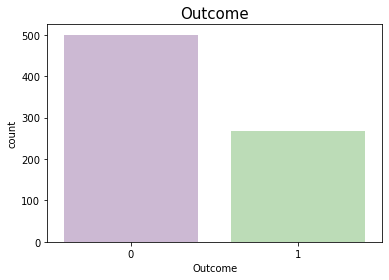

In [6]:
sns.countplot(data.Outcome, palette="PRGn")
plt.title("Outcome",fontsize=15)
plt.show()

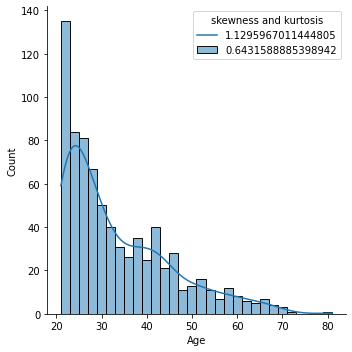

In [7]:
sns.displot( x = 'Age', data = data, bins = 30, kde = True)
skewness=str(data["Age"].skew())
kurtosis=str(data["Age"].kurt())
plt.legend([skewness,kurtosis],title=("skewness and kurtosis"))
plt.show();

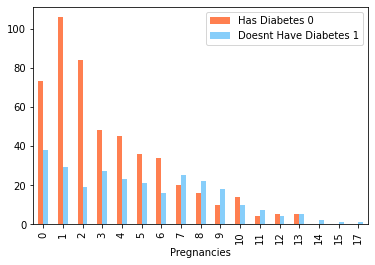

In [8]:
fig = pd.crosstab(data.Pregnancies, data.Outcome).plot(kind = 'bar', color = ['coral', 'lightskyblue', 'plum', 'khaki'])
plt.legend(['Has Diabetes 0', 'Doesnt Have Diabetes 1']);

In [9]:

# Age Distribution
fig = px.histogram(data, x="Age", marginal="box" )
fig.show()

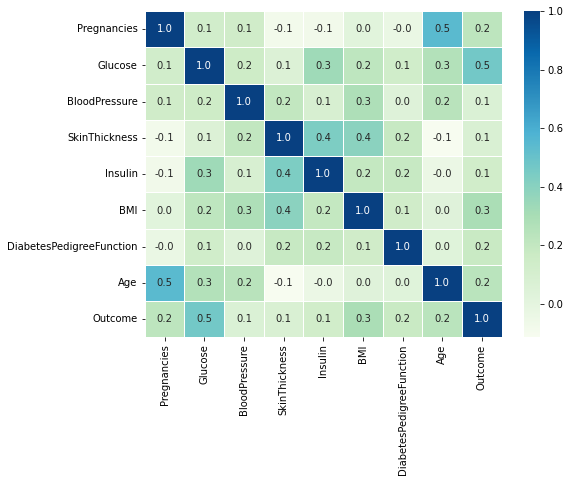

In [10]:
f,ax = plt.subplots(figsize=(8,6))
sns.heatmap(data.corr(), cmap="GnBu", annot=True, linewidths=0.5, fmt= '.1f',ax=ax)
plt.show()

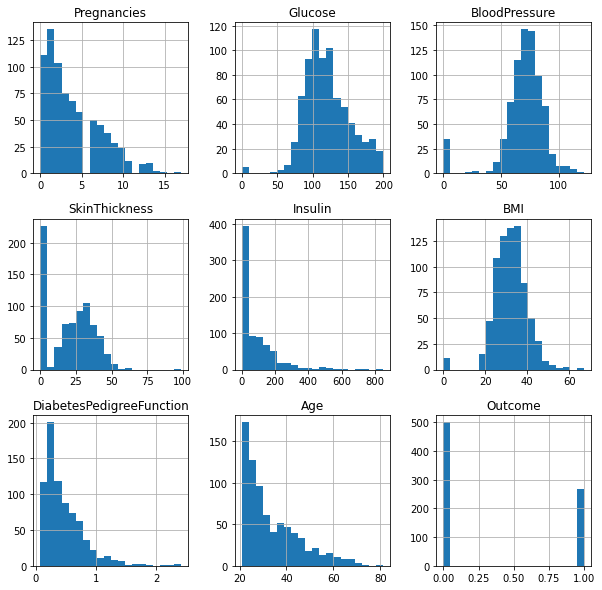

In [11]:
data.hist(bins=20,figsize=(10,10))
plt.show()

We observe that only glucose and Blood Pressure are normally distributed rest others are skewed and have outliers


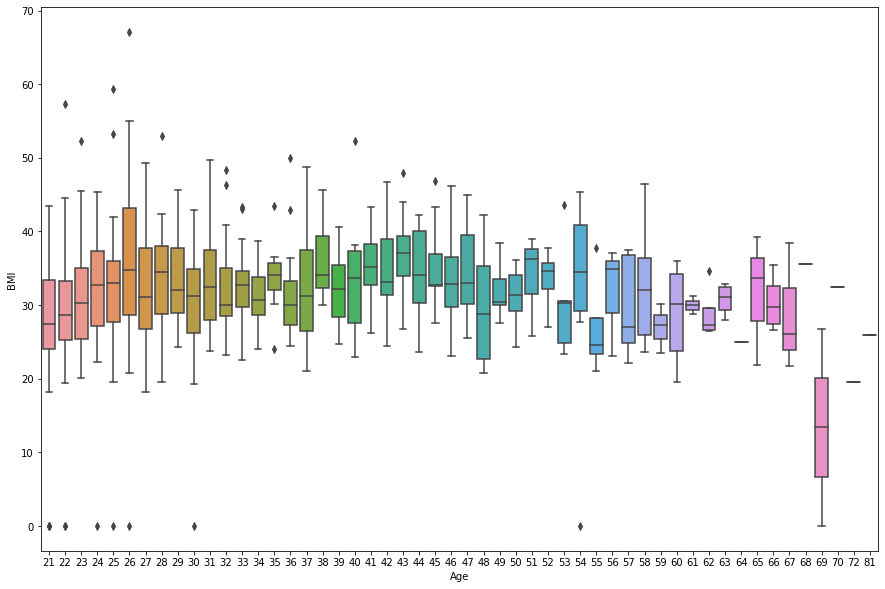

In [12]:
plt.subplots(figsize=(15,10))
sns.boxplot(x='Age', y='BMI', data=data)
plt.show()

In [13]:
num_feats = ['Pregnancies',    'Glucose', 'BloodPressure',
              'SkinThickness', 'Insulin', 'BMI',
              'DiabetesPedigreeFunction', 'Age']

In [14]:
L = len(num_feats)
ncol= 2
nrow= int(np.ceil(L/ncol))
#remove_last= (nrow * ncol) - L

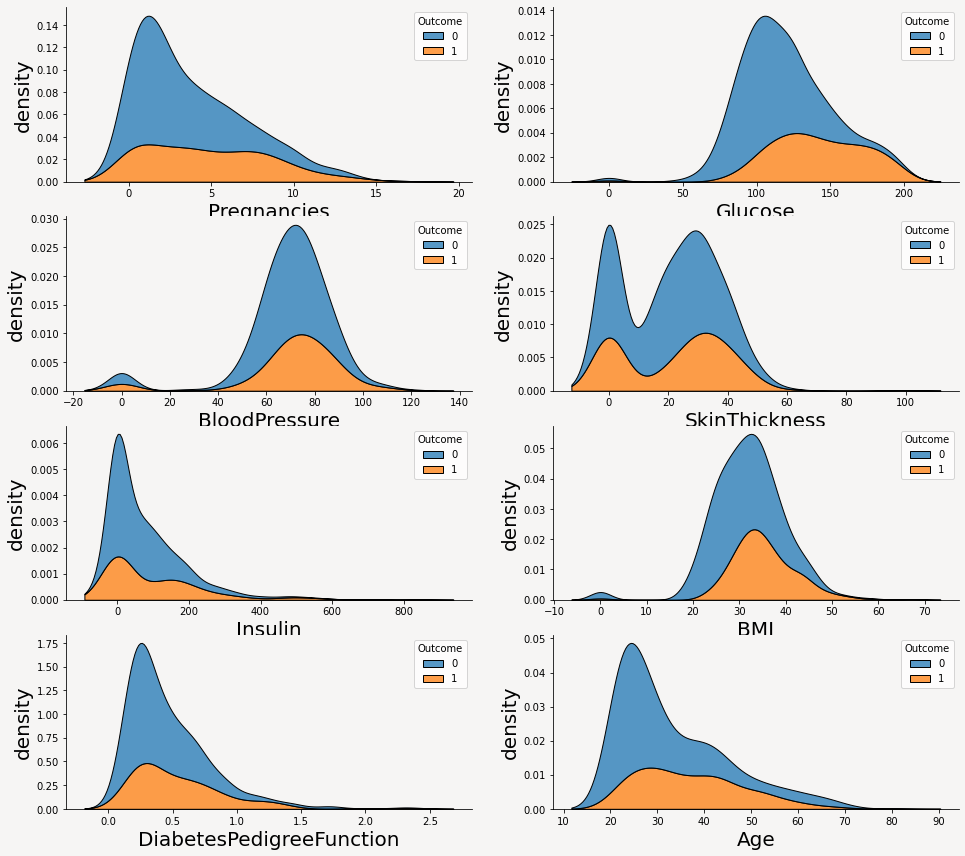

In [15]:
fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='#F6F5F4')   
fig.subplots_adjust(top=0.92)

i = 1
for col in num_feats:
    plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
    
    ax = sns.kdeplot(data=data, x=col , hue="Outcome", multiple="stack") 
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)
    
    i = i +1

## Model Building

In [16]:
x = data.drop(['Outcome'], axis = 1)
y = data.loc[:,"Outcome"].values

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 123)

In [18]:
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[139  18]
 [ 35  62]]


Accuracy of Logistic Regression: 79.13385826771653 

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       157
           1       0.78      0.64      0.70        97

    accuracy                           0.79       254
   macro avg       0.79      0.76      0.77       254
weighted avg       0.79      0.79      0.79       254



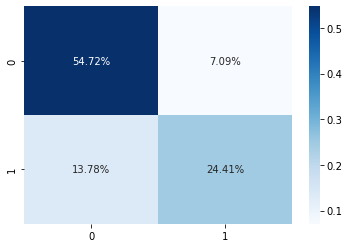

In [22]:
sns.heatmap(lr_conf_matrix/np.sum(lr_conf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [ ]:
y_prob = lr.predict_proba(x)[:, 1]
roc_auc_score(y, y_prob)

0.8366865671641791

Predicting on a random observation

In [ ]:
random_user = x.sample(1, random_state=44)
print(random_user)
lr.predict(random_user)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
452            0       91             68             32      210  39.9   

     DiabetesPedigreeFunction  Age  
452                     0.381   25  


array([0])

### Feature Importance

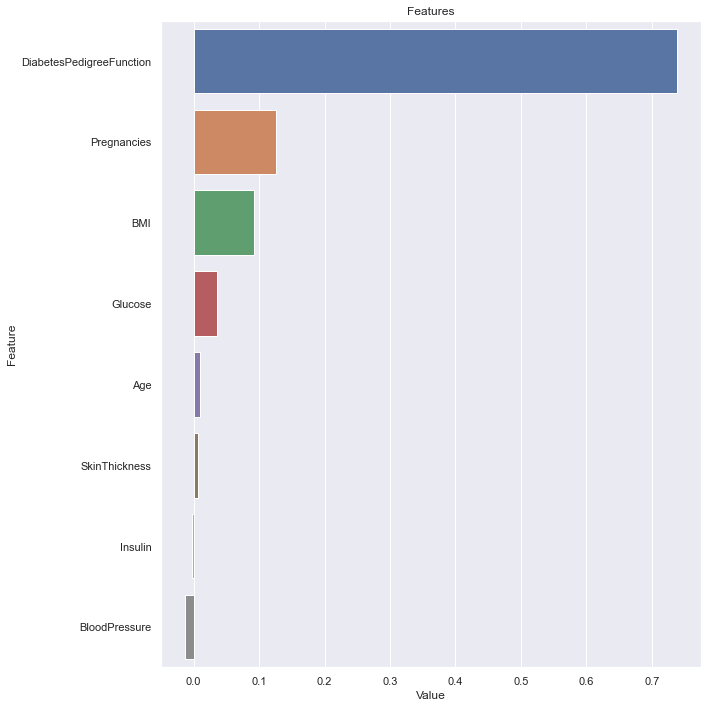

In [ ]:
feature_imp = pd.DataFrame({'Value': lr.coef_[0], 'Feature': x.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:8])
plt.title('Features')
plt.tight_layout()
plt.show()

## LightGBM model

In [1]:
import lightgbm as lgbm

OSError: dlopen(/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [23]:
# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(x,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


#number of combinations
n_iter = 300

In [25]:
#intialize lgbm and launch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(x, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

NameError: name 'lgbm' is not defined

In [ ]:
model_performance(lgbm_clf, 'LightGBM')
scores_table(lgbm_clf, 'LightGBM')

NameError: name 'model_performance' is not defined